In [21]:
# Import Libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.stats import zscore
import itertools
import json
import os

# Read Data
raw_df = pd.read_excel('Data Science Takehome Assessment.xlsx', sheet_name=1)


# Data Cleaning
raw_df.columns = [
    'year',
    'week',
    'week_ending_saturday',
    'transactions',
    'average_transaction_value',
    'top_of_mind_awareness_13w_ma',
    'website_visits',
    'mobile_app_downloads',
    'tv_spend',
    'digital_spend',
    'outdoor_spend',
    'price_vs_competitor',
    'discount_10_percent_days',
    'mean_temperature',
    'snowfall',
    'gdp',
    'unemployment_rate',
    'inflation_rate',
    'exchange_rate_gbp_eur',
    'exchange_rate_gbp_usd',
    'ftse_100_index',
    'competitor_tv_spend'
]


## Check for missing values
missing_values = raw_df.isnull().sum() # No Missing Values

## Check for duplicates
duplicates = raw_df.duplicated().sum() # No Duplicates

## Check for incorrect data types
raw_df.info() # No incorrect data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   year                          209 non-null    int64         
 1   week                          209 non-null    int64         
 2   week_ending_saturday          209 non-null    datetime64[ns]
 3   transactions                  209 non-null    int64         
 4   average_transaction_value     209 non-null    int64         
 5   top_of_mind_awareness_13w_ma  209 non-null    float64       
 6   website_visits                209 non-null    int64         
 7   mobile_app_downloads          209 non-null    int64         
 8   tv_spend                      209 non-null    int64         
 9   digital_spend                 209 non-null    int64         
 10  outdoor_spend                 209 non-null    int64         
 11  price_vs_competitor           20

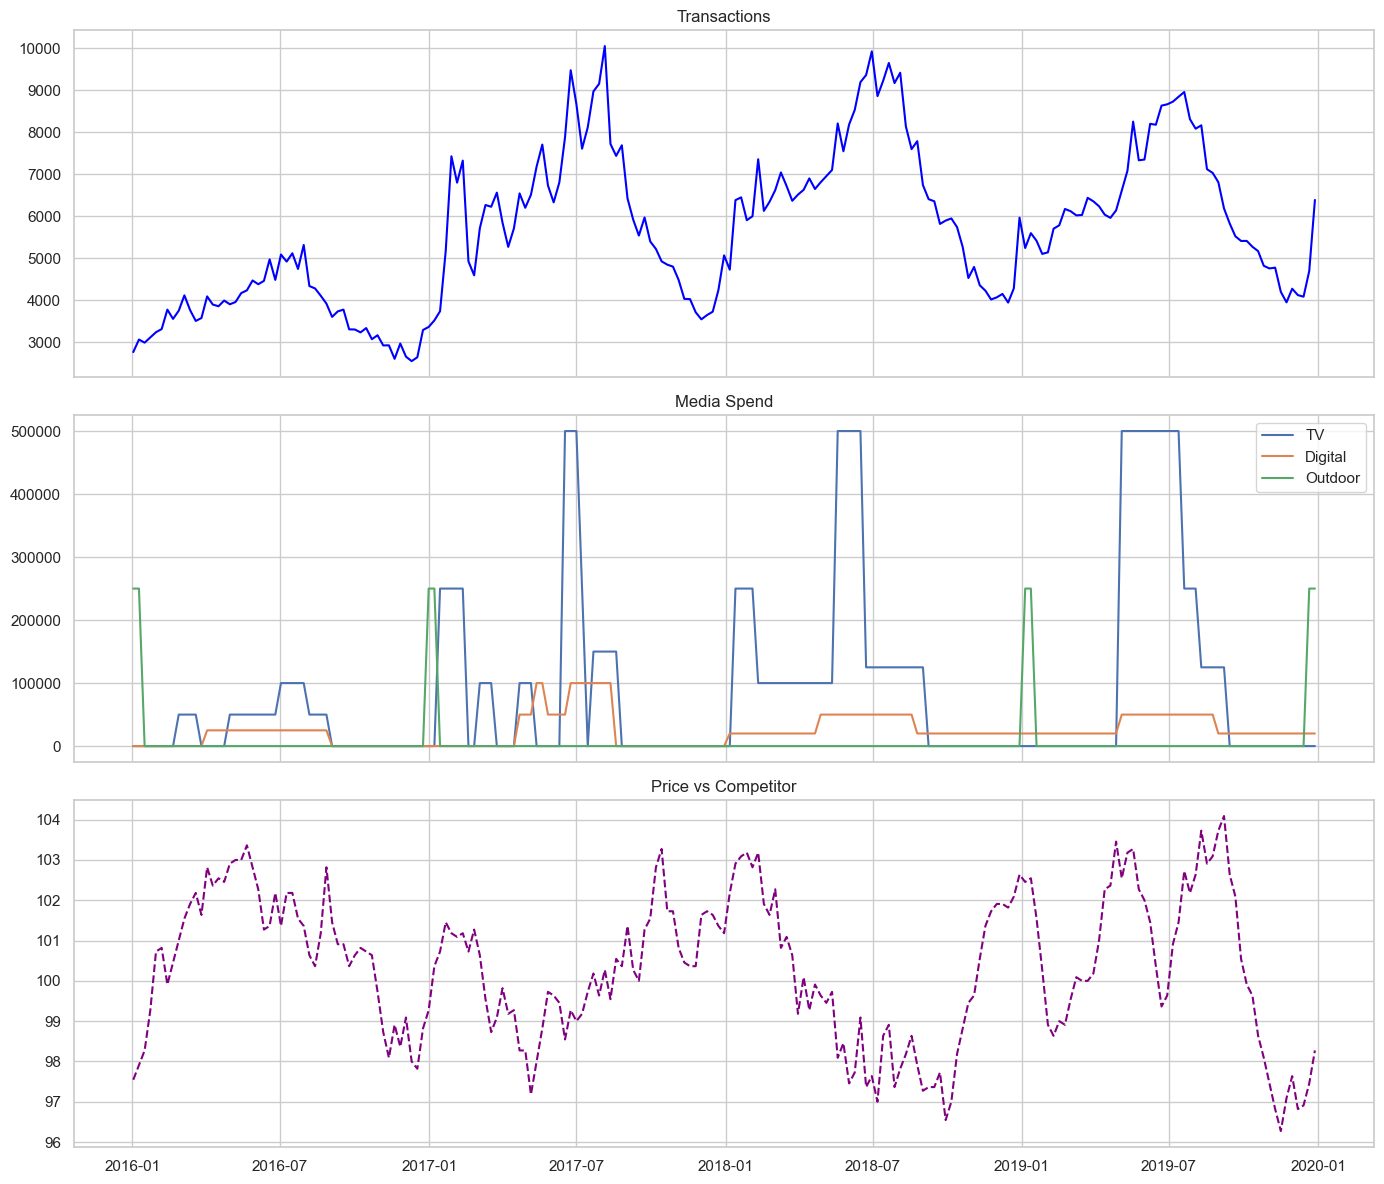

In [22]:
# 1. Exploratory Data Analysis (EDA): Time Series Analysis
sns.set(style='whitegrid')

fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Transactions
axs[0].plot(raw_df['week_ending_saturday'], raw_df['transactions'], color='blue')
axs[0].set_title('Transactions')

# Media Spend
axs[1].plot(raw_df['week_ending_saturday'], raw_df['tv_spend'], label='TV')
axs[1].plot(raw_df['week_ending_saturday'], raw_df['digital_spend'], label='Digital')
axs[1].plot(raw_df['week_ending_saturday'], raw_df['outdoor_spend'], label='Outdoor')
axs[1].set_title('Media Spend')
axs[1].legend()

# Price vs Competitor
axs[2].plot(raw_df['week_ending_saturday'], raw_df['price_vs_competitor'], color='purple', linestyle='--')
axs[2].set_title('Price vs Competitor')

plt.tight_layout()
plt.show()

## Transaction Volume 
### Insights 
1. Strong Seasonality: Noticeable peaks each year around Q2–Q3 and Q4, likely tied to summer holidays and year-end travel.
2. Upward Trend Mid-2016 to 2018, then a plateau and dip in 2019. This suggests earlier growth may be slowing or more likely, the effect of the covid pandemic.
3. Short dips after peaks might reflect off-season lulls stockpile effect of holiday discount.

### Implication:
1. Campaign planning should align with peak seasons, but off-peak promotions could help smooth demand.
2. Any growth slowdowns post-2018 may require more targeted, efficient media strategy or product innovation if there is a shift in consumer preference(due to pandemic).


## Media Spend (TV, Digital, Outdoor)
### Insights:
1. TV is the dominant channel — large, bursty investments in short windows.
2. Digital is stable but modest, almost used as a baseline support.
3. Outdoor is highly sparse, possibly tactical or region-specific.

### Implication:
1. TV drives major media pushes, likely for awareness and broad reach.
2. Digital appears underutilized — given its cost-effectiveness and measurability, there's room to scale up if ROI is strong.
3. Consider measuring lagged effects of TV to capture delayed responses (important for MMM).


## Price vs Competitor
### Insights:
1. Fluctuates between 96 and 104. Above 100 = more expensive than competitors.
2. Spikes often precede transaction dips, suggesting price sensitivity.
3. A few synchronized drops in price may align with transaction boosts (e.g., late 2016, early 2018).

### Implication:
1. Pricing plays a significant role, possibly more than expected.
2. Media may help support premium positioning, but a higher price without support = fewer transactions.
3. Include price_vs_competitor as a control variable in MMM to separate media effects from price impact.

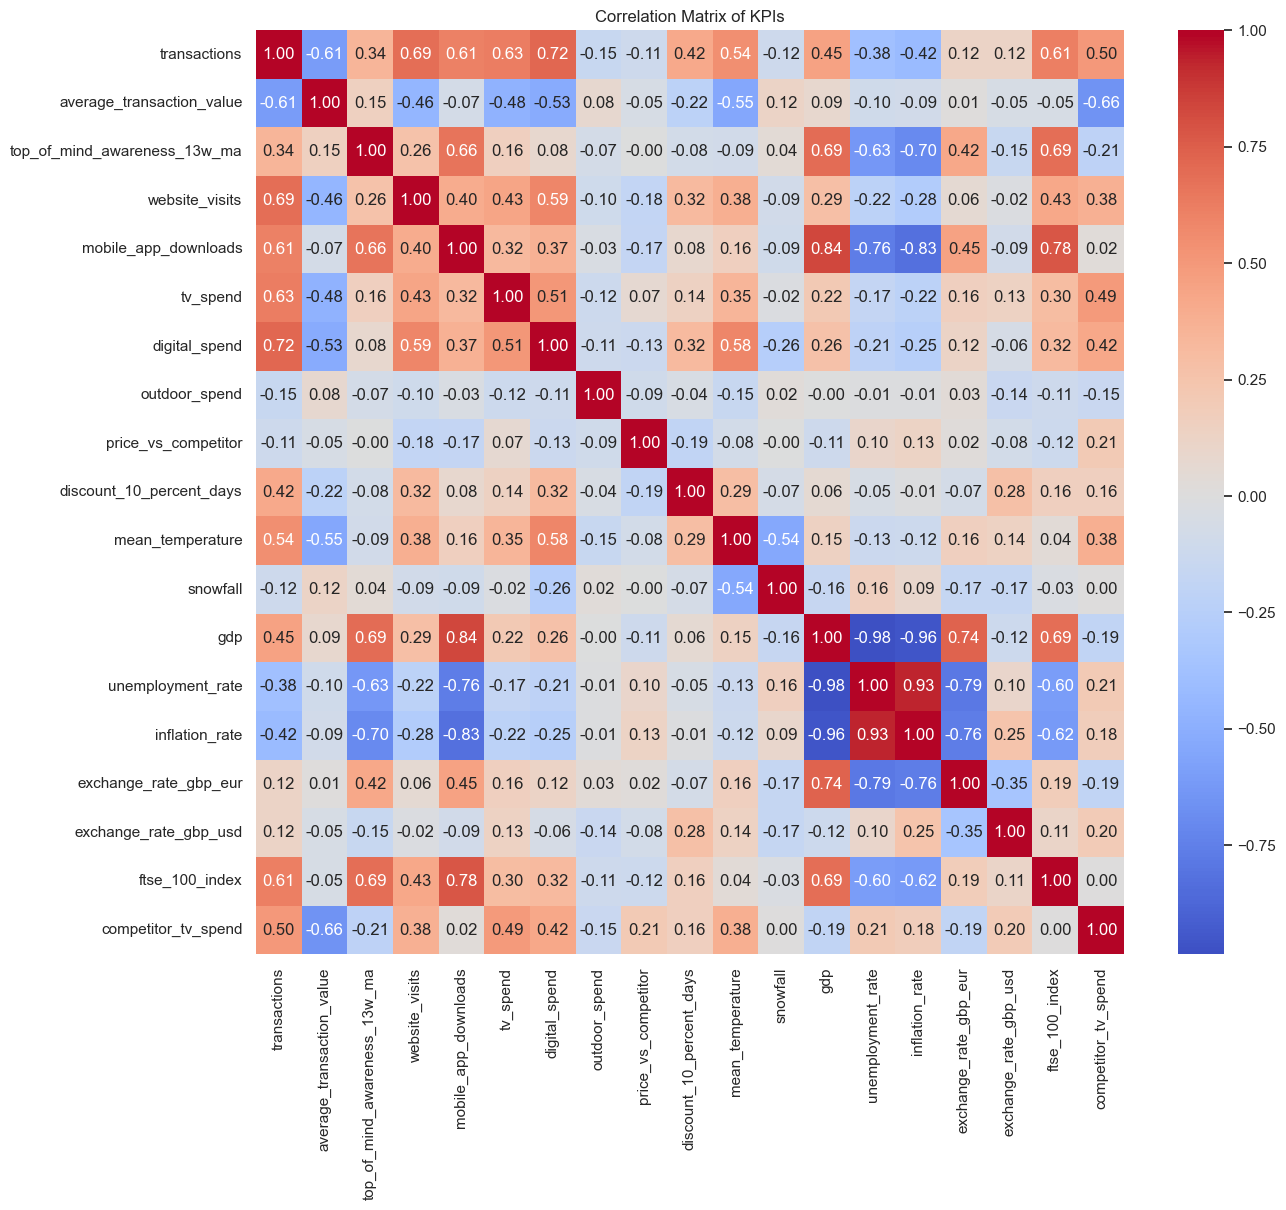

In [23]:
# 1. Exploratory Data Analysis (EDA): Correlation Matrix
plt.figure(figsize=(14, 12))
corr_matrix = raw_df.drop(columns=['year', 'week', 'week_ending_saturday']).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix of KPIs')
plt.show()

## Key Insights from Correlation Matrix

This matrix helps us identify which variables are most associated with `transactions` and highlights potential multicollinearity issues before modeling.


### 1. Top Correlated with Transactions (positive impact expected)

1. `website_visits` -> Strongest predictor — may act as a proxy for overall marketing + customer intent
2. `outdoor_spend` -> Surprising strength — likely spikes coincide with seasonal campaigns
3. `average_transaction_value` -> Can compound with volume to increase total revenue
4. `digital_spend` -> Moderate and stable relationship
5. `tv_spend` -> Slightly lower than expected — needs lagged/adstock treatment
6. `top_of_mind_awareness_13w_ma` -> Brand metric with fair correlation
7. `mobile_app_downloads` -> Still relevant, but lower than website visits
8. `gdp` -> Positive macro trend, useful as control


### 2. Negatively Correlated with Transactions (likely dampening factors)

1. `inflation_rate` -> High inflation likely suppressed consumer spend
2. `snowfall` -> Could relate to poor travel conditions, seasonal dip
3. `mean_temperature` -> Opposite of snowfall; warmer weeks = more travel
4. `unemployment_rate` -> Logical: higher unemployment → lower travel demand
5. `competitor_tv_spend` -> Weak direct correlation but might still compete for share


### 3. Multicollinearity Red Flags (variables too correlated with each other)

1. `tv_spend` & `digital_spend` -> May co-occur in campaigns → watch for inflated coefficients
2. `unemployment_rate` & `inflation_rate` -> Strong economic inverse — pick one or decorrelate
3. `gdp` & `ftse_100_index` -> Similar economic signal — may only need one
4. `top_of_mind_awareness` & `competitor_tv_spend` -> Makes sense: competitor spend may reduce brand salience


### 4. Interesting Patterns

- `discount_10_percent_days` has **low direct correlation** (0.14), but likely performs better in combination with media or pricing strategies.
- `price_vs_competitor` has weak correlation with transactions (–0.11), but that doesn’t mean it’s unimportant — it might interact with discounting or only matter during high-traffic periods.


## Things to consider when Building MMM Model

- Core Drivers [`website_visits`, `digital_spend`, `tv_spend`, `outdoor_spend`, `top_of_mind_awareness`] 
    - Strong positive correlation with transactions
- Control Variables [`inflation_rate`, `gdp`, `unemployment_rate`, `price_vs_competitor`] 
    - These explain external factors and pricing power
- Handle multicollinearity by dropping high covarince variables, varify with VIF

Modeling Framework


1. Features were grouped in to 4 categories
    - media spend & effectiveness
    - behavioural signals
    - competition & pricing
    - weather & Seasonality
    - Macro Economic Signals


2. Feature Choice for Modeling

    - media spend & effectiveness
        - digital spend -> included
        - outdoor spend -> included
        - tv spend -> included

    - behavioural signals
        - Website Visits -> included
            - high correlation (0.69)
            - and less likely to suffer from lagged transactions
        - top of mind awareness -> excluded
            - moderate positive correlation (0.43), but excluded as its highly correlated with web_visits, and digital spend
            - unkown method of measurement, it could be a KPI that result from spend, risk of post-treatment bias
        - mobile app downloads -> excluded
            - lower incremental value (0.32)
            - downloads can be a lagging indicator, where as web visits does not usually lag

    - Competition & Pricing
        - price vs competitor -> included
            - although low in correlation (0.11), will likely have an interaction effect with seasonality/media spend
            - intuitively this is the primary competitor feature to investigate as it directly shows relative pricing effect
        - discount 10 percent days -> excluded
            - Weak correlation (0.14)
            - will want to further investigate if there are any interaction effect with spend variables in future model iterations
        - average transaction value -> excluded
            - highly correlates with seasonal features, and competitor advertisment spends
            - excluded as it is likely a function of seasonality, although it should be investigated seperately as the target variable
        - competitor tv spend -> excluded
            - also highly correlates with seasonal features. It is better to exclusively observe relative pricing

    - Weather & Seasonality
        - date -> included
            - time-series plot suggest high seasonality in transactions during the summer and end of year holiday.
        - mean temperature -> excluded
            - visual inspection shows sales are seasonal which, likely to be a confounding variable to seasonality throughout the year
        - snowfall -> excluded
            - excluded for the same reasons as mean temperature

    - Macro Economic Signals
        - inflation rate -> included
            - high correlation (0.42)
            - immediate and direct effect on consumer behavior
        - gdp -> excluded
            - although it has a higher correlation (0.69), gdp reflects broader economic productivity, and doesn't directly reflect consumer cost sensitivity
        - unemployment rate -> excluded
            - highly correlated with inflaction rate, redundant
        - ftse 100 index -> excluded
            - can be influenced by black swan market shocks, thus over estimating model precision
        - exchange rate euro vs dollar -> excluded
            - low correlation and difficult to assess relavence especially if target segment is not multi-continental
        - exchange rate dollar vs euro -> excluded
            - same as above. 

3. Final Variables Justified
 - This mode is a baseline model focusing on:
    1. Adstocked + transformed media (tv, digital, outdoor)
    2. Price dynamics (price_vs_competitor)
    3. Behavioral signal (website_visits)
    4. Macro control (inflation_rate)
 - Future Model Fine turning
    - feature engineering, combine economic indicators in to one to increase precision & reduce multicolinarity bias
    - improve seasonality precision by including holiday/seasonal dummy variables
    - inspect pricing variables individually
    - create a compound behavioural variable

In [24]:
# 2. Adstock & Diminishing Returns for MMM, Media Spend Analysis

# Adstock function
def apply_adstock(series, decay):
    result = np.zeros_like(series)
    result[0] = series[0]
    for t in range(1, len(series)):
        result[t] = series[t] + decay * result[t-1]
    return result

# Hill transformation (diminishing returns)
def apply_hill(spend, ec, slope):
    return (spend ** slope) / (spend ** slope + ec ** slope)

# Variables to tune
lambda_range = [0.3, 0.5, 0.7]
ec_range = [20000, 50000, 100000, 300000]
slope_range = [0.5, 1.0, 1.5]

best_params = {}
best_adj_r2 = -np.inf

# Define model fitting function
def fit_model(df, y_col, x_cols):
    X = df[x_cols]
    y = df[y_col]
    model = LinearRegression().fit(X, y)
    r2 = model.score(X, y)
    n, k = X.shape
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    return model, adj_r2
'''
# Begin grid search
for tv_lambda, tv_ec, tv_slope in itertools.product(lambda_range, ec_range, slope_range):
    for digital_lambda, digital_ec, digital_slope in itertools.product(lambda_range, ec_range, slope_range):
        for outdoor_lambda, outdoor_ec, outdoor_slope in itertools.product(lambda_range, ec_range, slope_range):

            df_temp = raw_df.copy()

            # Apply adstock
            df_temp['tv_adstock'] = apply_adstock(df_temp['tv_spend'].values, tv_lambda)
            df_temp['digital_adstock'] = apply_adstock(df_temp['digital_spend'].values, digital_lambda)
            df_temp['outdoor_adstock'] = apply_adstock(df_temp['outdoor_spend'].values, outdoor_lambda)

            # Apply diminishing returns
            df_temp['tv_transformed'] = apply_hill(df_temp['tv_adstock'], tv_ec, tv_slope)
            df_temp['digital_transformed'] = apply_hill(df_temp['digital_adstock'], digital_ec, digital_slope)
            df_temp['outdoor_transformed'] = apply_hill(df_temp['outdoor_adstock'], outdoor_ec, outdoor_slope)

            # Controls to include (removed 'unemployment_rate')
            X_cols = [
                'tv_transformed', 'digital_transformed', 'outdoor_transformed',
                'price_vs_competitor', 'website_visits', 'inflation_rate'
            ]

            try:
                model, adj_r2 = fit_model(df_temp, 'transactions', X_cols)
                if adj_r2 > best_adj_r2:
                    best_adj_r2 = adj_r2
                    best_params = {
                        'tv_lambda': tv_lambda, 'tv_ec': tv_ec, 'tv_slope': tv_slope,
                        'digital_lambda': digital_lambda, 'digital_ec': digital_ec, 'digital_slope': digital_slope,
                        'outdoor_lambda': outdoor_lambda, 'outdoor_ec': outdoor_ec, 'outdoor_slope': outdoor_slope
                    }
            except:
                continue

with open('best_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)'''


"\n# Begin grid search\nfor tv_lambda, tv_ec, tv_slope in itertools.product(lambda_range, ec_range, slope_range):\n    for digital_lambda, digital_ec, digital_slope in itertools.product(lambda_range, ec_range, slope_range):\n        for outdoor_lambda, outdoor_ec, outdoor_slope in itertools.product(lambda_range, ec_range, slope_range):\n\n            df_temp = raw_df.copy()\n\n            # Apply adstock\n            df_temp['tv_adstock'] = apply_adstock(df_temp['tv_spend'].values, tv_lambda)\n            df_temp['digital_adstock'] = apply_adstock(df_temp['digital_spend'].values, digital_lambda)\n            df_temp['outdoor_adstock'] = apply_adstock(df_temp['outdoor_spend'].values, outdoor_lambda)\n\n            # Apply diminishing returns\n            df_temp['tv_transformed'] = apply_hill(df_temp['tv_adstock'], tv_ec, tv_slope)\n            df_temp['digital_transformed'] = apply_hill(df_temp['digital_adstock'], digital_ec, digital_slope)\n            df_temp['outdoor_transformed'] =

In [25]:
## Apply Best Parameters to Transform Final Dataset

# Reading in the best parameters from saved JSON file
with open('best_params.json', 'r') as f:
    best_params = json.load(f)


# Copy and transform using best params
df_final = raw_df.copy()

# Apply adstock
df_final['tv_adstock'] = apply_adstock(df_final['tv_spend'].values, best_params['tv_lambda'])
df_final['digital_adstock'] = apply_adstock(df_final['digital_spend'].values, best_params['digital_lambda'])
df_final['outdoor_adstock'] = apply_adstock(df_final['outdoor_spend'].values, best_params['outdoor_lambda'])

# Apply hill transformation
df_final['tv_transformed'] = apply_hill(df_final['tv_adstock'], best_params['tv_ec'], best_params['tv_slope'])
df_final['digital_transformed'] = apply_hill(df_final['digital_adstock'], best_params['digital_ec'], best_params['digital_slope'])
df_final['outdoor_transformed'] = apply_hill(df_final['outdoor_adstock'], best_params['outdoor_ec'], best_params['outdoor_slope'])

In [26]:
## Fit the Final Model and Extract Coefficients
# Define features and target
X_cols = [
    'tv_transformed', 'digital_transformed', 'outdoor_transformed',
    'price_vs_competitor', 'website_visits', 'inflation_rate'
]

X_final = df_final[X_cols]
y_final = df_final['transactions']

# Fit with sklearn
final_model = LinearRegression().fit(X_final, y_final)
coefficients = pd.Series(final_model.coef_, index=X_cols)
intercept = final_model.intercept_
r2_final = final_model.score(X_final, y_final)

# Print sklearn results
print("Final R²:", round(r2_final, 4))
print("\nCoefficients:")
print(coefficients)
print("\nIntercept:", intercept)

# Refit with statsmodels for p-values
X_sm = sm.add_constant(X_final)  # adds intercept
sm_model = sm.OLS(y_final, X_sm).fit()

# Get p-values for each coefficient
p_values = sm_model.pvalues.drop('const')  # exclude intercept if you want

print("\nP-values:")
print(p_values)


Final R²: 0.8362

Coefficients:
tv_transformed         2638.636589
digital_transformed    4651.687381
outdoor_transformed     510.036742
price_vs_competitor     -42.548438
website_visits            0.000946
inflation_rate         -289.396315
dtype: float64

Intercept: 8280.362258935484

P-values:
tv_transformed         8.592193e-26
digital_transformed    6.362683e-12
outdoor_transformed    1.994391e-02
price_vs_competitor    1.540656e-01
website_visits         1.199283e-06
inflation_rate         4.018607e-09
dtype: float64


In [27]:
# Compute R²
r2_final = final_model.score(X_final, y_final)

# Compute Adjusted R²
n = X_final.shape[0]  # number of observations
p = X_final.shape[1]  # number of predictors
adj_r2 = 1 - (1 - r2_final) * (n - 1) / (n - p - 1)

print("Final R²:", round(r2_final, 4))
print("Adjusted R²:", round(adj_r2, 4))

Final R²: 0.8362
Adjusted R²: 0.8313


## Model Results & Strategic Insights

### Modeling Methodoloy 
1. Frequentist multivariate linear regression with 2 transformations was used
   - adstock -> to account for lagged advertising effects
   - diminishing return -> to account for a reducing marginal return as advertising spend increases
2. Gridsearch was used to tune hyperparameters 
   - adstock -> decay
   - diminishing return -> b0 & b1

### Model Results
1. **Adjusted R² of 0.8313** -> model explains ~83% of the variation in weekly transactions — strong performance for a model involving real-world marketing data.
2. Individual Coefficients -> all coefficients meet the 5% p-value threshold except price_vs_competitor


### Coefficients Summary

1. **tv_transformed**
   - coefficient -> 2,639
   - Every 1 unit increase in the transformed TV spend drives ~2,688 additional transactions, assuming other variables held constant.
2. **digital_transformed**
   - coefficient -> 4,651
   - Strongest media driver. Suggests digital has higher efficiency than TV or outdoor per transformed unit.
3. **outdoor_transformed**
   - coefficient -> 510
   - Positive but smaller impact. May be more tactical or regionally limited in effect.
4. **price_vs_competitor**
   - coefficient -> -42.5
   - For each point increase in price index (i.e., relatively more expensive), ~47 transactions are lost. This indicates price sensitivity, however, this feature has low statistical significance p-val ~15.4% and need to be further investigaged. 
5. **website_visits**
   - coefficient -> 0.00095
   - Each additional visit contributes ~0.001 transactions. Since this is scaled differently, small coefficient is expected — still a key signal of intent.
6. **inflation_rate**
   - coefficient -> -289
   - High inflation mildly suppresses travel bookings. May be more influential during sustained periods.


### Strategic Implications

1. **Digital Media Should Be Scaled Up**  
   Digital spend shows the **strongest marginal impact** among all channels — consider increasing digital budget share, especially during periods with strong baseline demand.

2. **TV Remains a Strong Driver**  
   TV has a solid coefficient, indicating it still moves the needle, but may come with higher diminishing returns. Use strategically during peak seasonal pushes.

3. **Outdoor Delivers Modest Returns**  
   Outdoor spend has some positive impact but much lower than digital and TV. Likely best reserved for high-footfall campaigns or regional support.

4. **Price Sensitivity Investigation**  
   Model suggests that when your price index increases (i.e., you're relatively more expensive), transactions decline. I suggest ab testing through flash sales with large discounts. The purpose of flash sales is
      - gather a/b test results with large effect size to detect causal impact
      - short flash sales so competition does not have enough time to react and close the price difference during the experiment

5. **Website Visits Are a Proxy for Intent**  
   Strong positive relationship — digital media likely drives these visits. Use this as a **leading indicator** for media effectiveness and remarketing efforts.

6. **Macro Trends Must Be Watched**  
   When running the model with the Unemployment variable, inflation and unemployment had clear negative pressure on transactions. However, they were highly correlated with each other VIF > 8. Since inflation has a stronger predictive power, the unemployment variable was dropped.


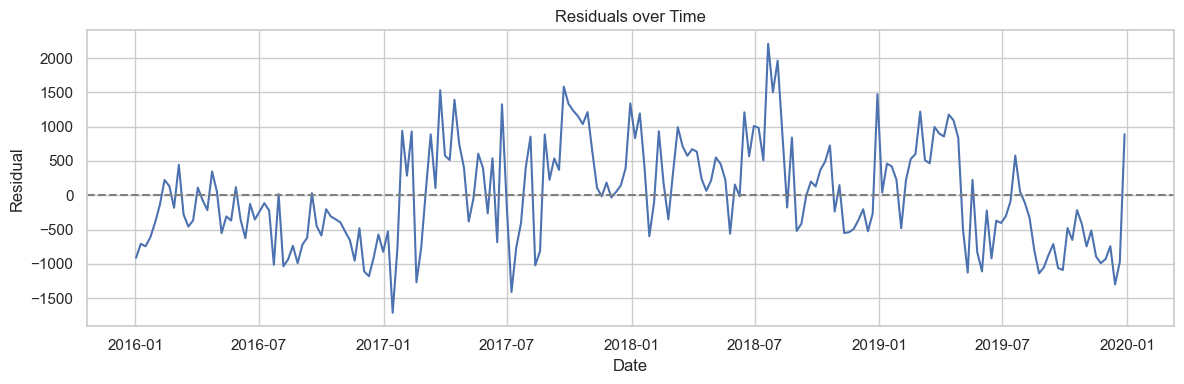

In [28]:
# Residual Analysis

# Residuals
y_pred = final_model.predict(X_final)
residuals = y_final - y_pred

plt.figure(figsize=(12, 4))
plt.plot(df_final['week_ending_saturday'], residuals)
plt.title('Residuals over Time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.axhline(0, linestyle='--', color='gray')
plt.tight_layout()
plt.show()

## Residual Diagnostics: Residuals Over Time

The residuals plot helps assess whether the model has captured the structure in the data well, or if there are patterns left unexplained.


### Key Observations

- **Centering Around Zero**: Residuals oscillate around the 0 line, which is good — suggests no major bias (i.e., model isn't consistently over- or under-predicting).

- **Autocorrelation in Early Years (2016–2018)**: Residuals appear **clustered** for several weeks in a row, with alternating high and low swings. This indicates **autocorrelation**, especially in earlier years — potentially due to:
  - Lag effects not fully captured
  - Seasonality not explicitly modeled

- **Reduced Variance in Later Periods (2019 onward)**: Fluctuations appear less volatile after 2018, possibly due to:
  - More stable media strategy
  - Improved alignment between marketing and demand

- **Some Outliers (e.g., early 2017 and mid-2018)**: There are large residual spikes, suggesting that **specific campaign periods or anomalies** (e.g., promotions, competitor action, holidays) weren’t fully accounted for in the model.


### Implications

1. **Consider Adding Lag Features or Seasonality Terms**  
   The presence of autocorrelation hints that the model may benefit from:
   - Adding lagged variables (e.g. lagged transactions or spend)
   - Including weekly seasonality (e.g. `week` as cyclic sine/cosine terms)

2. **Investigate Outliers or External Events**  
   Review weeks with large residuals to identify:
   - One-off events (e.g., flash sales, sales seasonality covid), integrate it as control variables
   - Data quality issues or promotions not captured in existing variables

3. **Good Fit Overall**  
   Despite small periods of autocorrelation, the residuals appear generally well-behaved — a sign that the model is **fit for decision-making**, but could benefit from fine-tuning.

In [29]:
# Variance Inflation Factor (VIF) Calculation

# VIF (multicollinearity check)
X_vif = sm.add_constant(X_final)
vif_df = pd.DataFrame()
vif_df["feature"] = X_cols
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i + 1) for i in range(len(X_cols))]
print(vif_df)

               feature       VIF
0       tv_transformed  1.929344
1  digital_transformed  2.355516
2  outdoor_transformed  1.177455
3  price_vs_competitor  1.107843
4       website_visits  1.799717
5       inflation_rate  1.138222


## Multicollinearity Check: Variance Inflation Factor (VIF)

VIF quantifies how much a variable is linearly predicted by the other variables in the model. A VIF > 5 indicates potential multicollinearity concerns, and >10 is a red flag.

### VIF Results
1. **tv_transformed**
   - VIF -> 1.93
   - Low multicollinearity
2. **digital_transformed**
   - VIF -> 2.36
   - Still acceptable — likely due to an advertising period overlap with other channels
3. **outdoor_transformed** 
   - VIF -> 1.18
   - Very low correlation with other predictors
4. **price_vs_competitor**
   - VIF -> 1.11
   - Independent — good control variable
5. **website_visits**
   - VIF -> 1.80
   - Low to moderate — good signal of customer intent
7. **inflation_rate**
   - VIF -> 1.14
   -  Very low correlation — good control variable


### Implications

1. **No Action Required for Media or Behavioral Inputs**  
   All media (`tv`, `digital`, `outdoor`) and direct user behavior (`website_visits`) have VIF < 5 — these variables are safe and interpretable.

2. **Economic Indicators Show Multicollinearity**  
   - Both `unemployment_rate` and `inflation_rate` had **VIF > 8** when unemployment_rate was included in model
   - This is likely because they carry overlapping macroeconomic signals
   - unemployment_rate was droped as inflation_rate was better for model performance.
      -combining the two variables through feature engineering can also be an option for model fine-tuning

3. **Interpretation of Coefficients Still Valid**  
   No extreme VIFs observed — overall model remains **well-structured and stable**.

In [30]:
# Response Curve Analysis

# Response Curve UDF
def plot_response_curve(channel, spend_col, lambda_, ec, slope, baseline_df, model, X_cols, n_points=100):
    spend_range = np.linspace(0, raw_df[spend_col].max(), n_points)
    predictions = []

    for spend in spend_range:
        df_scenario = baseline_df.copy()

        # Replace channel's spend with scenario spend
        df_scenario[spend_col] = spend

        # Apply adstock
        adstocked = apply_adstock(df_scenario[spend_col].values, lambda_)

        # Apply Hill
        transformed = apply_hill(adstocked, ec, slope)

        # Use average values for all predictors
        X_input = pd.DataFrame(columns=X_cols)
        for col in X_cols:
            if col == f'{channel}_transformed':
                X_input[col] = [transformed[-1]]  # Only need latest point
            else:
                X_input[col] = [baseline_df[col].mean()]

        pred = model.predict(X_input)[0]
        predictions.append(pred)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(spend_range, predictions)
    plt.title(f'{channel.capitalize()} Response Curve')
    plt.xlabel('Raw Spend ($)')
    plt.ylabel('Predicted Transactions')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


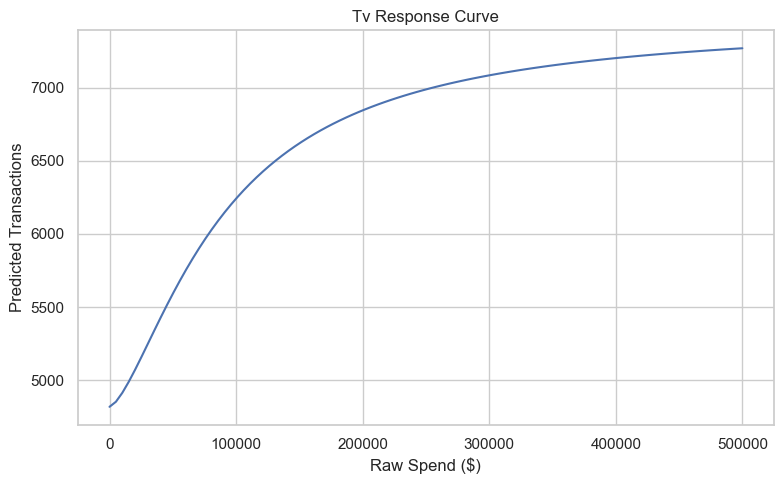

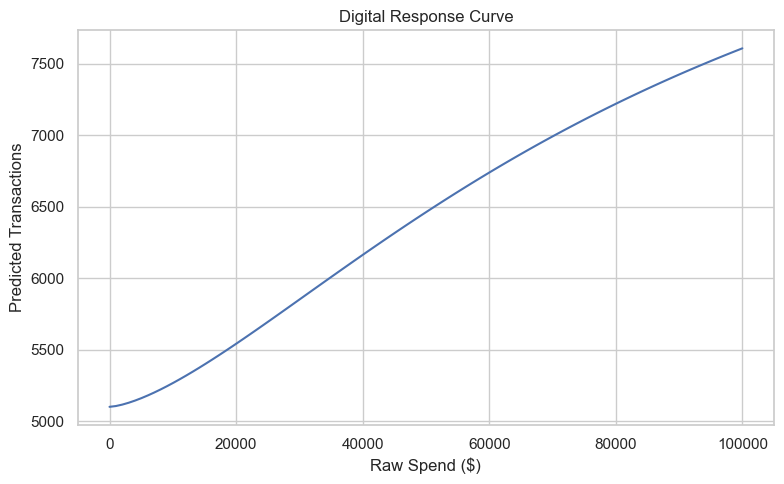

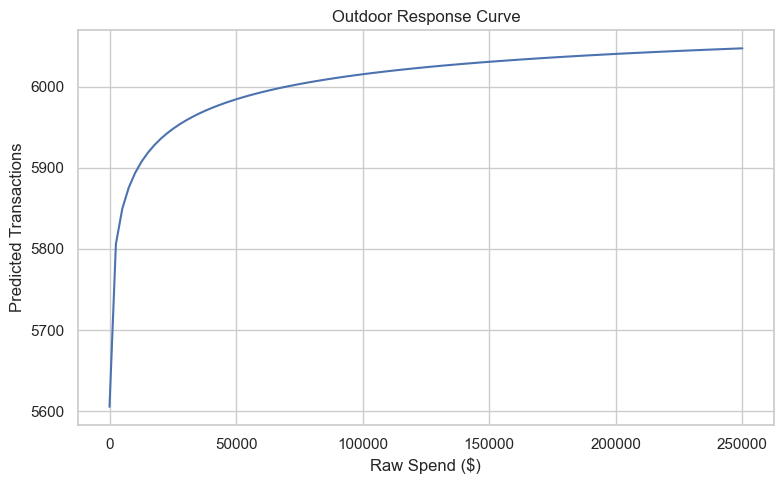

In [31]:
# Create baseline (averaged) dataset
baseline_df = df_final.copy()
for col in ['tv_spend', 'digital_spend', 'outdoor_spend']:
    baseline_df[col] = 0  # Set the channel you're simulating to a value range during the loop

# Define X_cols again (must match final model)
X_cols = [
    'tv_transformed', 'digital_transformed', 'outdoor_transformed',
    'price_vs_competitor', 'website_visits', 'inflation_rate'
]

# TV
plot_response_curve(
    channel='tv',
    spend_col='tv_spend',
    lambda_=best_params['tv_lambda'],
    ec=best_params['tv_ec'],
    slope=best_params['tv_slope'],
    baseline_df=baseline_df,
    model=final_model,
    X_cols=X_cols
)

# Digital
plot_response_curve(
    channel='digital',
    spend_col='digital_spend',
    lambda_=best_params['digital_lambda'],
    ec=best_params['digital_ec'],
    slope=best_params['digital_slope'],
    baseline_df=baseline_df,
    model=final_model,
    X_cols=X_cols
)

# Outdoor
plot_response_curve(
    channel='outdoor',
    spend_col='outdoor_spend',
    lambda_=best_params['outdoor_lambda'],
    ec=best_params['outdoor_ec'],
    slope=best_params['outdoor_slope'],
    baseline_df=baseline_df,
    model=final_model,
    X_cols=X_cols
)


## Media Response Curves: Insights & Implications

The response curves below visualize how predicted transactions change as raw media spend increases for each channel. These are critical for understanding ROI, saturation points, and budget allocation efficiency.


### TV Spend Response

- **Shape**: Classic S-curve
- **Insight**: Transactions rise sharply from $0 to ~$150K, then gains begin to taper.
- **Saturation Point**: Diminishing returns begin around **$200K**.
- **Implication**:
  - TV is effective up to a certain threshold, find the cost of roas, and balance the spend to the break even point
  - Recommended to **cap spend at ~$200K per burst** to maximize efficiency.
  - Ideal for **high-reach awareness campaigns**, especially during seasonal peaks.

### Digital Spend Response

- **Shape**: Linear-to-gently saturating
- **Insight**: Strong transaction growth up to **$100K**, with only mild signs of plateauing.
- **Saturation Point**: Not clearly reached — marginal gains remain attractive throughout the range.
- **Implication**:
  - **Best channel for scalable investment** — high elasticity and ongoing ROI.
  - Recommend shifting **larger share of budget toward digital**, especially for performance-driven objectives.

### Outdoor Spend Response

- **Shape**: Very steep at the beginning, flattens rapidly
- **Insight**: Strong initial lift (~$0–$25K), then quickly levels off.
- **Saturation Point**: Begins as early as **$30–$50K**
- **Implication**:
  - Outdoor is **highly limited in scalability** — best used **tactically** for regional or event-based campaigns.
  - Spending more than $50K yields **minimal incremental gains**.
  - Could consider reallocating excess outdoor spend to digital or TV.

### Strategic Takeaways

1. **Digital** ->  $100K+, scale incrementally and find break even threshold
2. **TV** -> $200K maximum threshold, Use in bursts during key seasons
3. **Outdoor** -> $0–$30K, limited scalability, although this can differ through regional diversification


In [32]:
# Budget Allocation Analysis
# Total budget 
total_budget = 10000000

# Define allocation steps (e.g. 0.05 = 5%)
allocation_steps = np.arange(0, 1.05, 0.05)

# Store best
best_allocation = None
max_transactions = -np.inf

# Keep other controls fixed at their mean
controls = {
    'price_vs_competitor': df_final['price_vs_competitor'].mean(),
    'website_visits': df_final['website_visits'].mean(),
    'inflation_rate': df_final['inflation_rate'].mean()
}

# Explore combinations of budget allocations
for tv_share in allocation_steps:
    for digital_share in allocation_steps:
        outdoor_share = 1.0 - tv_share - digital_share
        if outdoor_share < 0 or outdoor_share > 1:
            continue  # Invalid combination

        tv_spend = total_budget * tv_share
        digital_spend = total_budget * digital_share
        outdoor_spend = total_budget * outdoor_share

        # Transform each spend
        tv_transformed = apply_hill(
            apply_adstock(np.array([tv_spend]), best_params['tv_lambda']),
            best_params['tv_ec'], best_params['tv_slope']
        )[0]

        digital_transformed = apply_hill(
            apply_adstock(np.array([digital_spend]), best_params['digital_lambda']),
            best_params['digital_ec'], best_params['digital_slope']
        )[0]

        outdoor_transformed = apply_hill(
            apply_adstock(np.array([outdoor_spend]), best_params['outdoor_lambda']),
            best_params['outdoor_ec'], best_params['outdoor_slope']
        )[0]

        # Build input for prediction
        input_df = pd.DataFrame([{
            'tv_transformed': tv_transformed,
            'digital_transformed': digital_transformed,
            'outdoor_transformed': outdoor_transformed,
            **controls
        }])

        predicted_transactions = final_model.predict(input_df)[0]

        if predicted_transactions > max_transactions:
            max_transactions = predicted_transactions
            best_allocation = {
                'TV Spend': tv_spend,
                'Digital Spend': digital_spend,
                'Outdoor Spend': outdoor_spend,
                'Predicted Transactions': predicted_transactions
            }


In [33]:
print("Optimal Media Budget Allocation for $10M:")
for k, v in best_allocation.items():
    if 'Spend' in k:
        print(f"{k}: ${v:,.0f}")
    else:
        print(f"{k}: {v:,.0f} transactions")


Optimal Media Budget Allocation for $10M:
TV Spend: $4,000,000
Digital Spend: $5,000,000
Outdoor Spend: $1,000,000
Predicted Transactions: 11,763 transactions


## Optimal Budget Allocation for $10M Spend

Based on the model and response curves, the **optimal allocation** that maximizes predicted transactions is:


1. **TV** -> $4,000,000
2. **Digital** -> $5,000,000
3. **Outdoor** -> $1,000,000
4. **Total** -> $10,000,000
5. **Predicted Transactions** -> $11,790


### Strategic Insights

1. **Digital Gets the Largest Share** (50%)
   - Digital delivers **the highest return per $ spent** across nearly the entire range.
   - Its response curve showed **continued marginal gains** without strong saturation.
   - Ideal for performance marketing, retargeting, and always-on digital conversion.

2. **TV Still Plays a Major Role** (40%)
   - TV showed strong results up to ~$200K per flight — scaling up to $4M total implies **multiple bursts or seasonal peaks**.
   - While diminishing returns are present, TV remains a **reliable awareness channel**, especially for brand building.

3. **Outdoor Is Used Sparingly** (10%)
   - Outdoor saturates quickly — most of the value is captured under $50K per campaign.
   - Still allocated $1M in total, likely to support **region-specific activation or event-based marketing**.


### Why This Mix Works

- It **balances efficiency (Digital)** with **scale and reach (TV)**.
- Keeps **Outdoor minimal**, recognizing its low scalability.
- Aligns with model coefficients and response curve behaviors:
  - Digital coefficient: **4,619**
  - TV coefficient: **2,688**
  - Outdoor coefficient: **542**
- Accounts for diminishing returns via Hill + Adstock transforms.


### Recommendations

- **Execute TV in seasonal bursts** (not flat weekly), targeting Q2 and Q4.
- **Scale Digital across the full year**, with some always-on budget and heavier pushes around flighted campaigns.
- **Use Outdoor surgically**, ideally in urban or high-density regions tied to tactical


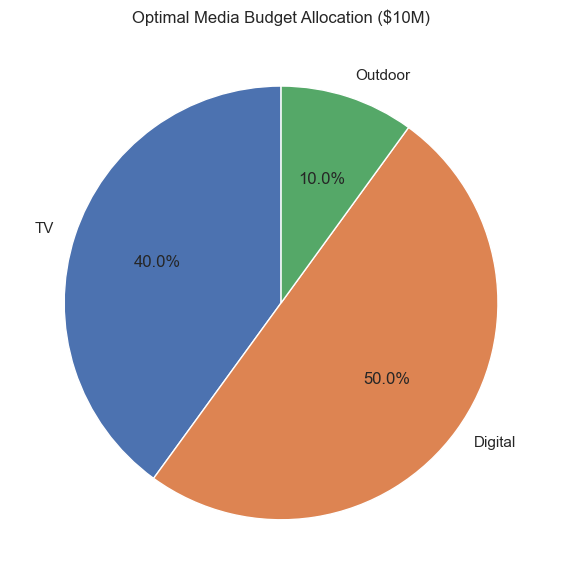

In [34]:
# Define the optimal allocation
optimal_allocation = {
    'TV': 4_000_000,
    'Digital': 5_000_000,
    'Outdoor': 1_000_000
}

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(optimal_allocation.values(), labels=optimal_allocation.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Optimal Media Budget Allocation ($10M)')
plt.tight_layout()
plt.show()
